In [222]:
from __future__ import print_function

import gzip
import itertools
import pickle
import os
import sys
import numpy as np
import lasagne
import theano
from lasagne.layers import dnn  # fails early if not available
import theano.tensor as T
import time

PY2 = sys.version_info[0] == 2

if PY2:
    from urllib import urlretrieve

    def pickle_load(f, encoding):
        return pickle.load(f)
else:
    from urllib.request import urlretrieve

    def pickle_load(f, encoding):
        return pickle.load(f, encoding=encoding)


NUM_EPOCHS = 500
BATCH_SIZE = 600
LEARNING_RATE = 0.05
MOMENTUM = 0.9


DATA_URL = 'http://deeplearning.net/data/mnist/mnist.pkl.gz'
DATA_FILENAME = '/home/ddashti/lasagne/siamese_mnist/mnist.pkl.gz'


def _load_data(url=DATA_URL, filename=DATA_FILENAME):
    if not os.path.exists(filename):
        print("Downloading MNIST")
        urlretrieve(url, filename)

    with gzip.open(filename, 'rb') as f:
        return pickle_load(f, encoding='latin-1')

def aug_data(X, y):
    X_aug = np.concatenate((X, X), axis=1)

    idx = range(len(X))
    np.random.shuffle(idx)
    X_aug[:, 1, :, :] = X[idx, 0]
    
    y_aug = y[idx] == y
    return X_aug, y_aug

def load_data():
    data = _load_data()
    X_train, y_train = data[0]
    X_valid, y_valid = data[1]
    X_test, y_test = data[2]

    # reshape for convolutions
    X_train = X_train.reshape((X_train.shape[0], 1, 28, 28))
    X_valid = X_valid.reshape((X_valid.shape[0], 1, 28, 28))
    X_test = X_test.reshape((X_test.shape[0], 1, 28, 28))
    
    X_train, y_train_pair = aug_data(X_train, y_train)
    X_valid, y_valid_pair = aug_data(X_valid, y_valid)

    return dict(
        X_train=lasagne.utils.floatX(X_train),
        y_train_pair=y_train_pair.astype('int32'),
        y_train=y_train.astype('int32'),
        X_valid=lasagne.utils.floatX(X_valid),
        y_valid_pair=y_valid_pair.astype('int32'),
        y_valid=y_valid.astype('int32'),
        num_examples_train=X_train.shape[0],
        num_examples_valid=X_valid.shape[0],
        input_height=X_train.shape[2],
        input_width=X_train.shape[3],
    )


def build_model(input_var=None,input_width=28, input_height=28,batch_size=BATCH_SIZE):
    l_in = lasagne.layers.InputLayer(
        shape=(None, 2, input_width, input_height),input_var=input_var
    )

    l_c2b = lasagne.layers.ReshapeLayer(l_in, (-1, 1, [2], [3]))
    
    l_conv1 = dnn.Conv2DDNNLayer(
        l_c2b,
        num_filters=20,
        filter_size=(5, 5),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.Uniform(),
    )
    l_pool1 = dnn.MaxPool2DDNNLayer(l_conv1, pool_size=(2, 2))
    
    l_hidden1 = lasagne.layers.DenseLayer(
        l_pool1,
        num_units=2,
        nonlinearity=lasagne.nonlinearities.identity,
        W=lasagne.init.Uniform(),
    )
        
    l_out = lasagne.layers.ReshapeLayer(l_hidden1, (-1, 2, [1]))

    return l_out


def create_iter_functions(output_layer,X,y,
                          learning_rate=LEARNING_RATE, 
                          momentum=MOMENTUM):    
    
    a = lasagne.layers.get_output(output_layer)
    #output_layer.get_output_for(X)
    
    d = T.sum((a[:, 0] - a[:, 1])**2, -1)
    loss = T.mean(y * d + 
                  (1 - y) * T.maximum(0, 1 - d))

    all_params = lasagne.layers.get_all_params(output_layer)
    updates = lasagne.updates.nesterov_momentum(
        loss, all_params, learning_rate, momentum)

    iter_train = theano.function(
        [X, y], loss,
        updates=updates,on_unused_input='warn',
    )
    
    iter_valid = theano.function(
        [X, y], loss,on_unused_input='warn',
        )

    return {'train':iter_train,
        'valid':iter_valid}
"""
dict(
        train=iter_train,
        valid=iter_valid,
        )
"""

def train(iter_funcs, dataset, batch_size=BATCH_SIZE):
    num_batches_train = dataset['num_examples_train'] // batch_size
    num_batches_valid = dataset['num_examples_valid'] // batch_size

    batch_train_losses = []
    for batch_index in range(num_batches_train):
        batch_slice = slice(
            batch_index * batch_size, (batch_index + 1) * batch_size)
        batch_train_loss = iter_funcs['train'](dataset['X_train'][batch_slice], 
                                               dataset['y_train_pair'][batch_slice])
        batch_train_losses.append(batch_train_loss)

    avg_train_loss = np.mean(batch_train_losses)

    batch_valid_losses = []
    for batch_index in range(num_batches_valid):
        batch_slice = slice(
            batch_index * batch_size, (batch_index + 1) * batch_size)
        batch_valid_loss = iter_funcs['valid'](dataset['X_valid'][batch_slice], 
                                               dataset['y_valid_pair'][batch_slice])
        batch_valid_losses.append(batch_valid_loss)

    avg_valid_loss = np.mean(batch_valid_losses)

    return {
        'train_loss': avg_train_loss,
        'valid_loss': avg_valid_loss,
        }


def main(num_epochs=NUM_EPOCHS):
    print("Loading data...")
    dataset = load_data()

    print("Building model and compiling functions...")
    #output_layer = build_model(28, 28)
    X = T.tensor4()
    y = T.ivector()
    output_layer=build_model(X,28,28)
    iter_funcs = create_iter_functions(output_layer,X,y)

    print("Starting training...")
    now = time.time()
    try:
        i = 0
        while 1:
            epoch = train(iter_funcs, dataset)
            i += 1
            epoch['number'] = i
            print("Epoch {} of {} took {:.3f}s".format(epoch['number'], num_epochs, time.time() - now))
            now = time.time()
            print("  training loss:\t\t{:.6f}".format(epoch['train_loss']))
            print("  validation loss:\t\t{:.6f}".format(epoch['valid_loss']))
#            print("  validation accuracy:\t\t{:.2f} %%".format(
#                epoch['valid_accuracy'] * 100))

            if epoch['number'] >= num_epochs:
                break

    except KeyboardInterrupt:
        pass

    return output_layer


In [149]:
temp=load_data()
X_train=temp['X_train']
y_train=temp['y_train_pair']
print(temp.keys())

['num_examples_train', 'X_train', 'y_train_pair', 'num_examples_valid', 'X_valid', 'y_valid', 'input_height', 'input_width', 'y_train', 'y_valid_pair']


In [225]:
def build_model(input_var=None,input_width=28, input_height=28,batch_size=BATCH_SIZE):
    l_in = lasagne.layers.InputLayer(
        shape=(None, 2, input_width, input_height),input_var=input_var
    )

    l_c2b = lasagne.layers.ReshapeLayer(l_in, (-1, 1, [2], [3]))
    
    l_conv1 = dnn.Conv2DDNNLayer(
        l_c2b,
        num_filters=20,
        filter_size=(2, 2),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.Uniform(),
    )
    l_pool1 = dnn.MaxPool2DDNNLayer(l_conv1, pool_size=(2, 2))
    """
    l_conv2 = dnn.Conv2DDNNLayer(
        l_pool1,
        num_filters=50,
        filter_size=(2, 2),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.Uniform(),
    )
    #l_pool2 = dnn.MaxPool2DDNNLayer(l_conv2, pool_size=(2, 2))
    
    l_hidden1 = lasagne.layers.DenseLayer(
        l_pool2,
        num_units=500,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.Uniform(),
    )
    """
    l_hidden2 = lasagne.layers.DenseLayer(
        l_pool1,
        num_units=2,
        nonlinearity=lasagne.nonlinearities.identity,
        W=lasagne.init.Uniform(),
    )
        
    l_out = lasagne.layers.ReshapeLayer(l_hidden2, (-1, 2, [1]))

    return l_out

In [226]:
trained_net=main(num_epochs=20)


Loading data...
Building model and compiling functions...
Starting training...
Epoch 1 of 20 took 1.215s
  training loss:		0.901819
  validation loss:		0.897682
Epoch 2 of 20 took 1.192s
  training loss:		0.632477
  validation loss:		0.184627
Epoch 3 of 20 took 1.193s
  training loss:		0.176400
  validation loss:		0.164986
Epoch 4 of 20 took 1.184s
  training loss:		0.167311
  validation loss:		0.162101
Epoch 5 of 20 took 1.174s
  training loss:		0.162207
  validation loss:		0.155807
Epoch 6 of 20 took 1.164s
  training loss:		0.152594
  validation loss:		0.145006
Epoch 7 of 20 took 1.241s
  training loss:		0.140484
  validation loss:		0.135042
Epoch 8 of 20 took 1.177s
  training loss:		0.131649
  validation loss:		0.129929
Epoch 9 of 20 took 1.183s
  training loss:		0.125736
  validation loss:		0.127250
Epoch 10 of 20 took 1.181s
  training loss:		0.121636
  validation loss:		0.124978
Epoch 11 of 20 took 1.203s
  training loss:		0.118721
  validation loss:		0.122720
Epoch 12 of 20 to

In [80]:
lasagne.layers.get_all_layers(trained_net)

In [204]:
X = T.tensor4()
out = theano.function([X],lasagne.layers.get_output(trained_net,inputs=X))

In [205]:
p = out(dataset['X_valid'])

In [109]:
d = np.sum((p[:, 0] - p[:, 1])**2, -1)
d.shape

(10000,)

(array([  4.00600000e+03,   2.42900000e+03,   1.61700000e+03,
          8.59000000e+02,   5.94000000e+02,   3.10000000e+02,
          1.36000000e+02,   4.00000000e+01,   5.00000000e+00,
          4.00000000e+00]),
 array([  7.22768251e-04,   3.26738442e+00,   6.53404608e+00,
          9.80070774e+00,   1.30673694e+01,   1.63340310e+01,
          1.96006927e+01,   2.28673544e+01,   2.61340160e+01,
          2.94006777e+01,   3.26673393e+01]),
 <a list of 10 Patch objects>)

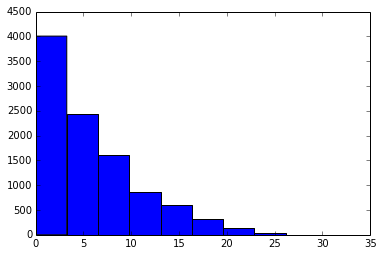

In [107]:
plt.hist(d)

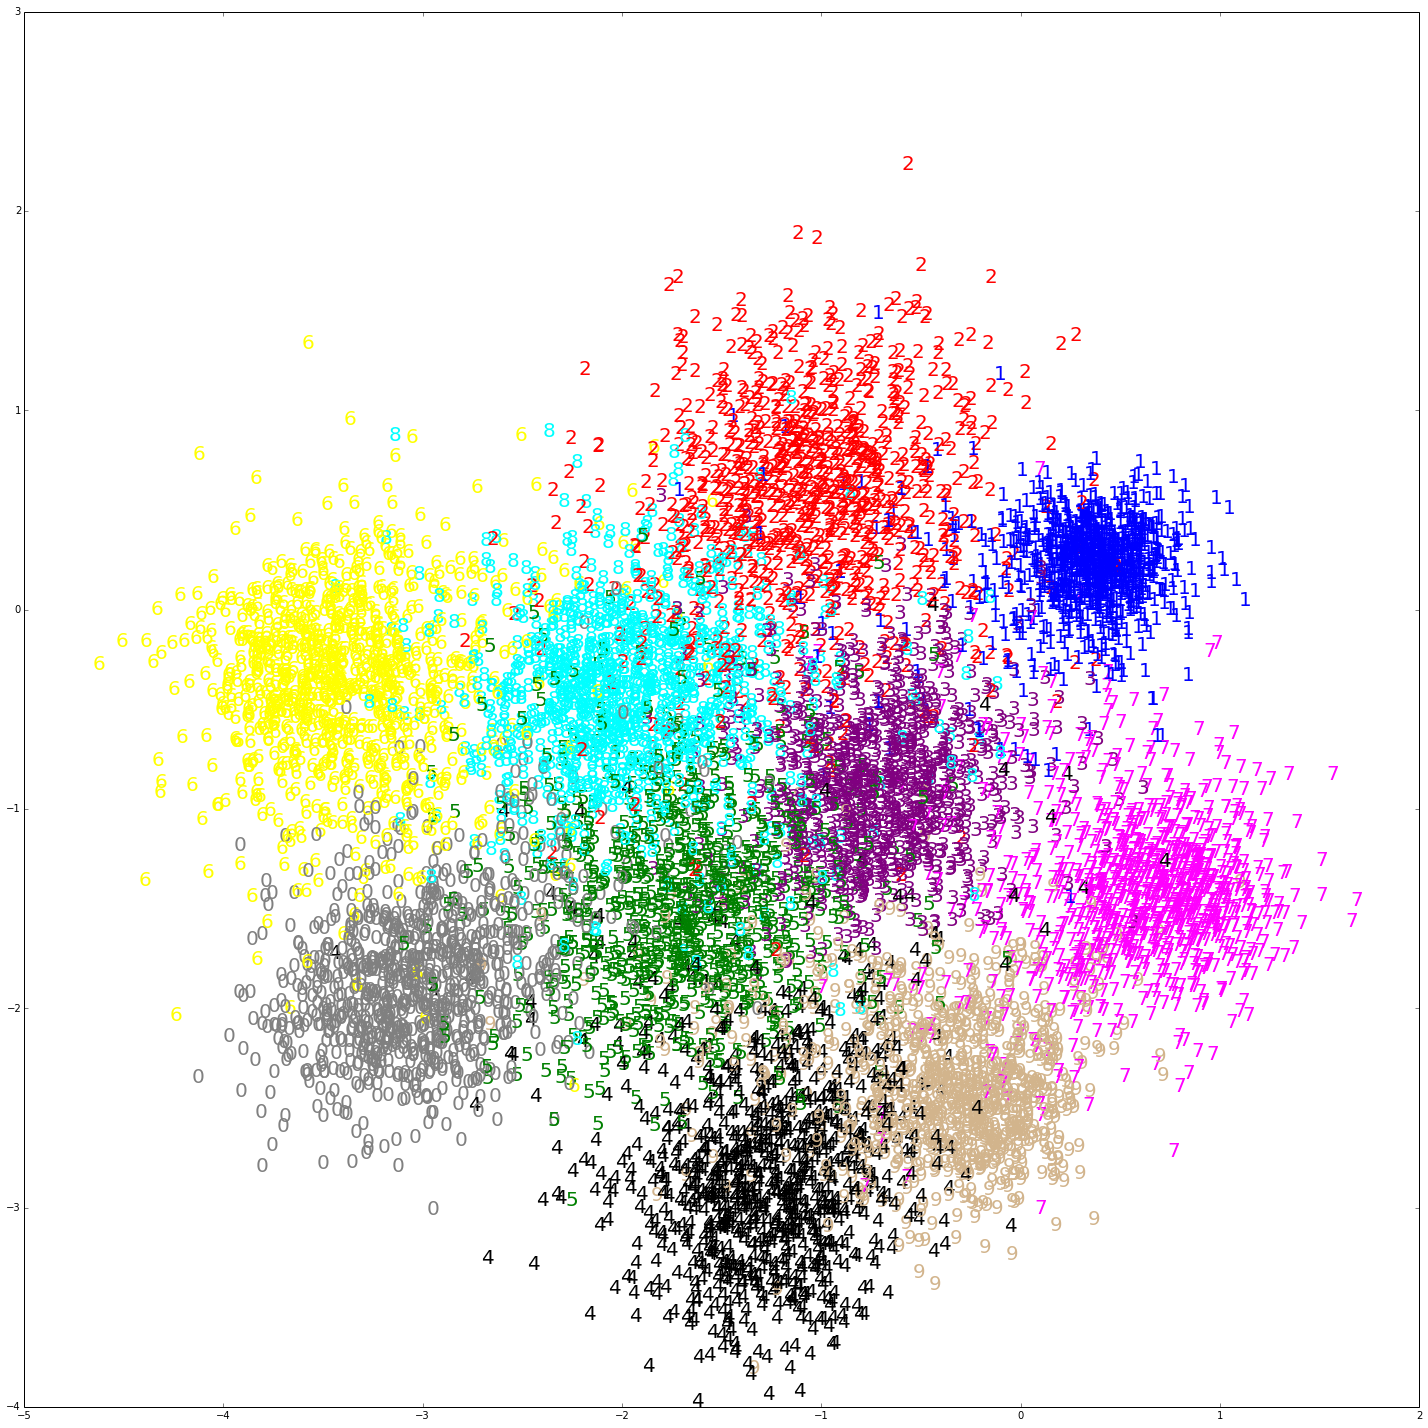

In [144]:
plt.figure(figsize=(25,25))
plt.plot(p[:,0,0], p[:,0,1],'.',color='white')
color_dic={'1':'blue','2':'red','3':'purple'
           ,'4':'black','5':'green','6':'yellow','7':'magenta','8':'cyan','9':'tan','0':'gray'}
for i in range(len(dataset['y_valid'][:])):
    #print(str(dataset['y_valid'][i]))
    num=str(dataset['y_valid'][i])
    plt.annotate(num,xy=(p[i,0,0],p[i,0,1]),fontsize=20,color=color_dic[num])

## comparing to t-distributed Stochastic Neighbor Embedding (TSNE)

In [86]:
from tsne import bh_sne

In [87]:
X0 = dataset['X_valid'][:,0,:,:].reshape((10000,-1)).astype('float64')

In [89]:
p1 = bh_sne(X0)

In [101]:
p1.shape

(10000, 2)

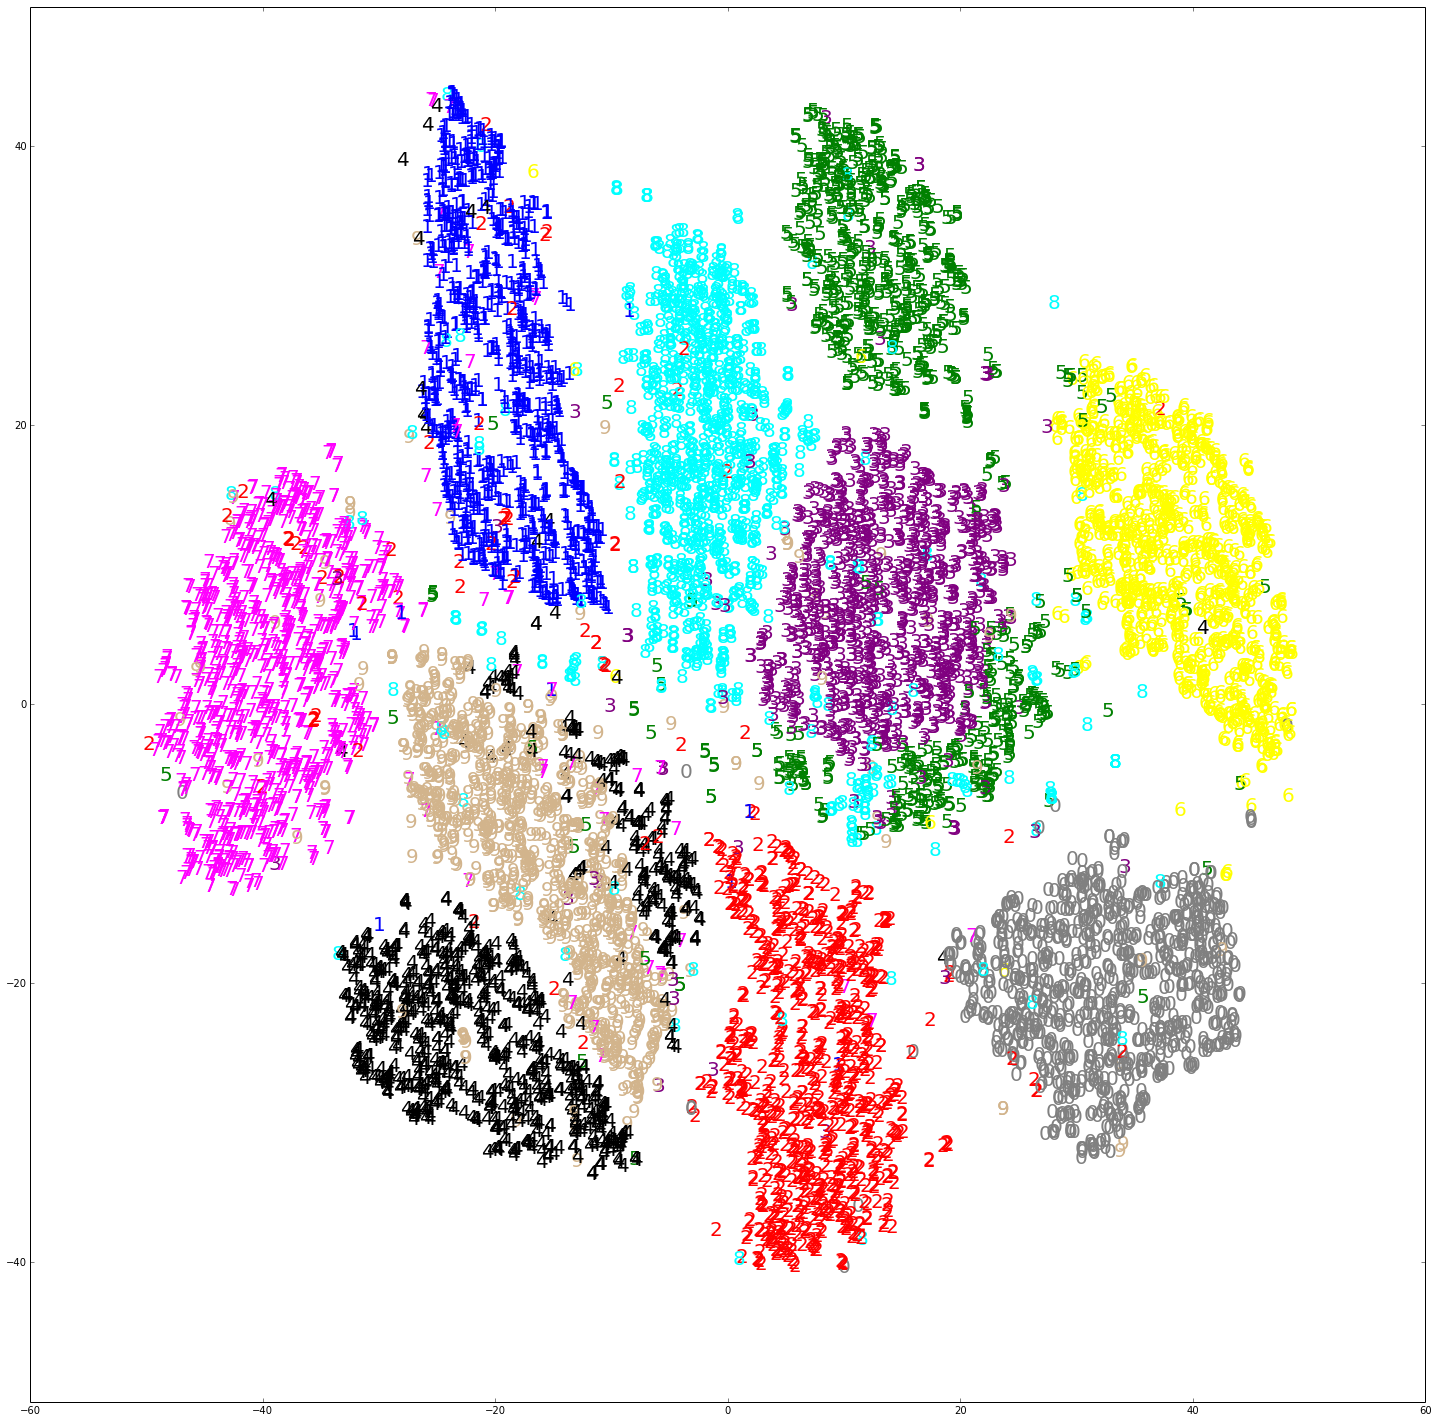

In [145]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.plot(p1[:,0], p1[:,1],'.')
plt.figure(figsize=(25,25))
plt.plot(p1[:,0], p1[:,1],'.',color='white')
color_dic={'1':'blue','2':'red','3':'purple'
           ,'4':'black','5':'green','6':'yellow','7':'magenta','8':'cyan','9':'tan','0':'gray'}
for i in range(len(dataset['y_valid'][:])):
    #print(str(dataset['y_valid'][i]))
    num=str(dataset['y_valid'][i])
    plt.annotate(str(dataset['y_valid'][i]),xy=(p1[i,0],p1[i,1]),color=color_dic[num],fontsize=20)

In [94]:
theano.printing.pydotprint(out)

The output file is available at /home/ddashti/.theano/compiledir_Linux-3.19--generic-x86_64-with-Ubuntu-14.04-trusty-x86_64-2.7.6-64/theano.pydotprint.gpu0.png


In [95]:
img=plt.imread('/home/ddashti/.theano/compiledir_Linux-3.19--generic-x86_64-with-Ubuntu-14.04-trusty-x86_64-2.7.6-64/theano.pydotprint.gpu0.png')

In [227]:
plt.figure(figsize=(250,100))
plt.imshow(img)